In [32]:
## import modules
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from keras.utils import to_categorical
from keras.models import load_model, Model
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard, LambdaCallback,\
ReduceLROnPlateau

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import os
import numpy as np
from IPython.display import Image

%matplotlib inline

In [3]:
# parameters
batch_size = 128 # weights/ bias are updated after seeing these many observations
num_classes = 10 # since we have 10 digits, so 10 predictions
epochs = 20 # number of times, the model will go over all the data

img_rows, img_cols = 28, 28

In [4]:
# download the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

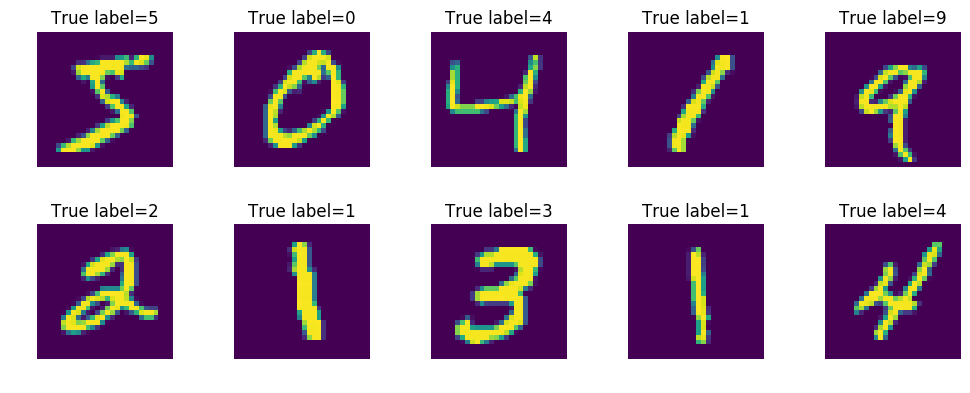

In [5]:
# plot some digits and their labels
plt.figure(figsize=(10,4), dpi=100)

for i in range(10):
    img = x_train[i]
    label = y_train[i]
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title('True label=' + str(label))
    plt.axis('off')
    
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'distribution of digits in train set')

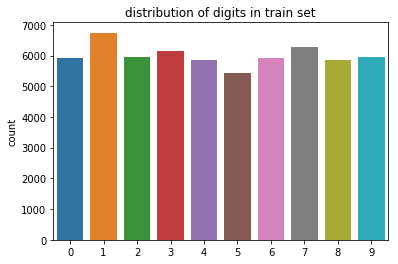

In [6]:
# distribution of digits in train set
sns.countplot(y_train).set_title('distribution of digits in train set')

Text(0.5, 1.0, 'distribution of digits in test set')

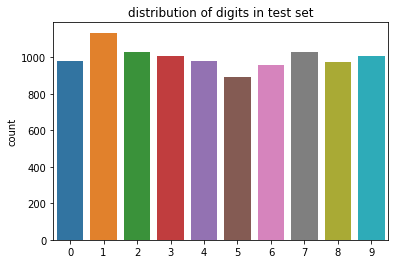

In [7]:
# distribution of digits in test set
sns.countplot(y_test).set_title('distribution of digits in test set')

In [37]:
# since we are dealing CNN network, images need to be 28,28,1
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
    
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.
print(x_train.shape[0], 'train samples, each with shape', x_train.shape[1:])
print(x_test.shape[0], 'test samples, each with shape', x_test.shape[1:])

60000 train samples, each with shape (784,)
10000 test samples, each with shape (784,)


In [9]:
# convert class vectors to binary class matrices
print ('before converting to categorical', y_train[0])
y_train = to_categorical(y_train, num_classes)
print ('before converting to categorical', y_train[0])

before converting to categorical 5
before converting to categorical [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [11]:
# # intialize Sequential and then add two Conv2D layers
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape, name='conv2d_1'))
# model.add(Conv2D(64, (3, 3), activation='relu', name='conv2d_2'))
# model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool_1'))
# model.add(Dropout(0.25, name='dropout_1'))
# model.add(Flatten(name='flatten'))
# model.add(Dense(128, activation='relu', name='dense_1'))
# model.add(Dropout(0.5, name='dropout_2'))
# model.add(Dense(num_classes, activation='softmax', name='output'))

# model.summary()

In [22]:
# functional API
inputs = Input(shape=(784,), name='input')
x = Dense(512, activation='relu', input_shape=(784,), name='dense_1')(inputs)
x = Dropout(0.2, name='dropout_1')(x)
x = Dense(512, activation='relu', name='dense_2')(x)
x = Dropout(0.2, name='dropout_2')(x)
predictions = Dense(num_classes, activation='softmax', name='dense_3')(x)

model = Model(inputs, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [23]:
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [25]:
filepath = '{epoch:02d}-{val_loss:.2f}.hdf5'
modelCheckpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0,\
                                  save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Save the model after every epoch.

# filepath can contain named formatting options, which will be filled with the values of epoch 
# and keys in logs (passed in on_epoch_end).

# For example: if filepath is weights.{epoch:02d}-{val_loss:.2f}.hdf5, then the model checkpoints
#     will be saved with the epoch number and the validation loss in the filename.

# Arguments

# ** filepath: string, path to save the model file.
# ** monitor: quantity to monitor.
# ** verbose: verbosity mode, 0 or 1.
# ** save_best_only: if save_best_only=True, the latest best model according to the quantity monitored 
#     will not be overwritten.
# ** save_weights_only: if True, then only the model's weights will be saved (model.save_weights(filepath))
#     , else the full model is saved (model.save(filepath)).
# ** mode: one of {auto, min, max}. If save_best_only=True, the decision to overwrite the current save 
#     file is made based on either the maximization or the minimization of the monitored quantity. 
#     For val_acc, this should be max, for val_loss this should be min, etc. In auto mode, the 
#     direction is automatically inferred from the name of the monitored quantity.
# ** period: Interval (number of epochs) between checkpoints.

In [26]:
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', \
                              baseline=None, restore_best_weights=False)

# Stop training when a monitored quantity has stopped improving.

# Arguments

# ** monitor: quantity to be monitored.
# ** min_delta: minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
#     change of less than min_delta, will count as no improvement.
# ** patience: number of epochs with no improvement after which training will be stopped.
# ** verbose: verbosity mode.
# ** mode: one of {auto, min, max}. In min mode, training will stop when the quantity monitored has stopped 
#     decreasing; in max mode it will stop when the quantity monitored has stopped increasing; in auto 
#     mode, the direction is automatically inferred from the name of the monitored quantity.
# ** baseline: Baseline value for the monitored quantity to reach. Training will stop if the model doesn't 
#     show improvement over the baseline.
# ** restore_best_weights: whether to restore model weights from the epoch with the best value of the monitored 
#     quantity. If False, the model weights obtained at the last step of training are used.

In [27]:
def scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

learningRateScheduler = LearningRateScheduler(scheduler, verbose=1)

# Arguments

# ** schedule: a function that takes an epoch index as input (integer, indexed from 0) and current 
#     learning rate and returns a new learning rate as output (float).
# ** verbose: int. 0: quiet, 1: update messages.

In [28]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, \
                          write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None,\
                          embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

# TensorBoard basic visualizations.

# TensorBoard is a visualization tool provided with TensorFlow.

# This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training 
# and test metrics, as well as activation histograms for the different layers in your model.

# If you have installed TensorFlow with pip, you should be able to launch TensorBoard from the command line:

# tensorboard --logdir=/full_path_to_your_logs
# When using a backend other than TensorFlow, TensorBoard will still work (if you have TensorFlow installed), 
# but the only feature available will be the display of the losses and metrics plots.

# Arguments

# ** log_dir: the path of the directory where to save the log files to be parsed by TensorBoard.
# ** lhistogram_freq: frequency (in epochs) at which to compute activation and weight histograms for the layers of 
#     the model. If set to 0, histograms won't be computed. Validation data (or split) must be specified for 
#     histogram visualizations.
# ** lbatch_size: size of batch of inputs to feed to the network for histograms computation.
# ** lwrite_graph: whether to visualize the graph in TensorBoard. The log file can become quite large when write_graph 
#     is set to True.
# ** lwrite_grads: whether to visualize gradient histograms in TensorBoard.  histogram_freq must be greater than 0.
# ** lwrite_images: whether to write model weights to visualize as image in TensorBoard.
# ** lembeddings_freq: frequency (in epochs) at which selected embedding layers will be saved. If set to 0, embeddings 
#     won't be computed. Data to be visualized in TensorBoard's Embedding tab must be passed as embeddings_data.
# ** lembeddings_layer_names: a list of names of layers to keep eye on. If None or empty list all the embedding layer 
#     will be watched.
# ** lembeddings_metadata: a dictionary which maps layer name to a file name in which metadata for this embedding layer
#     is saved. See the details about metadata files format. In case if the same metadata file is used for all 
#     embedding layers, string can be passed.
# ** lembeddings_data: data to be embedded at layers specified in  embeddings_layer_names. Numpy array (if the model 
# has a single input) or list of Numpy arrays (if the model has multiple inputs). Learn more about embeddings.
# ** lupdate_freq: 'batch' or 'epoch' or integer. When using 'batch', writes the losses and metrics to TensorBoard 
#     after each batch. The same applies for 'epoch'. If using an integer, let's say 10000, the callback will 
#     write the metrics and losses to TensorBoard every 10000 samples. Note that writing too frequently to 
#     TensorBoard can slow down your training.

/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [33]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto',\
                                      min_delta=0.0001, cooldown=0, min_lr=0)

# Reduce learning rate when a metric has stopped improving.

# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
# This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the
# learning rate is reduced.

# Arguments

# ** monitor: quantity to be monitored.
# ** factor: factor by which the learning rate will be reduced. new_lr = lr * factor
# ** patience: number of epochs with no improvement after which learning rate will be reduced.
# ** verbose: int. 0: quiet, 1: update messages.
# ** mode: one of {auto, min, max}. In min mode, lr will be reduced when the quantity monitored has stopped 
#     decreasing; in max mode it will be reduced when the quantity monitored has stopped increasing; in 
#     auto mode, the direction is automatically inferred from the name of the monitored quantity.
# ** min_delta: threshold for measuring the new optimum, to only focus on significant changes.
# ** cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
# ** min_lr: lower bound on the learning rate.

In [34]:
lambdaCallback = LambdaCallback(on_epoch_begin=None, on_epoch_end=None, on_batch_begin=None, \
                                              on_batch_end=None, on_train_begin=None, on_train_end=None)

# Print the batch number at the beginning of every batch.
batch_print_callback = LambdaCallback(
    on_batch_begin=lambda batch,logs: print(batch))

# Stream the epoch loss to a file in JSON format. The file content
# is not well-formed JSON but rather has a JSON object per line.
import json
json_log = open('loss_log.json', mode='wt', buffering=1)
json_logging_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: json_log.write(
        json.dumps({'epoch': epoch, 'loss': logs['loss']}) + '\n'),
    on_train_end=lambda logs: json_log.close()
)

# Terminate some processes after having finished model training.
"""
processes = ["python.exe"]
cleanup_callback = LambdaCallback(
    on_train_end=lambda logs: [
        p.terminate() for p in processes if p.is_alive()])
"""
# Callback for creating simple, custom callbacks on-the-fly.

# This callback is constructed with anonymous functions that will be called at the appropriate time. Note that 
# the callbacks expects positional arguments, as:

# on_epoch_begin and on_epoch_end expect two positional arguments: epoch, logs
# on_batch_begin and on_batch_end expect two positional arguments: batch, logs
# on_train_begin and on_train_end expect one positional argument: logs
# Arguments

# ** on_epoch_begin: called at the beginning of every epoch.
# ** on_epoch_end: called at the end of every epoch.
# ** on_batch_begin: called at the beginning of every batch.
# ** on_batch_end: called at the end of every batch.
# ** on_train_begin: called at the beginning of model training.
# ** on_train_end: called at the end of model training.


'\nprocesses = ["python.exe"]\ncleanup_callback = LambdaCallback(\n    on_train_end=lambda logs: [\n        p.terminate() for p in processes if p.is_alive()])\n'

In [35]:
callbacks = [modelCheckpoint, earlyStopping, learningRateScheduler, tensorboard, reduceLROnPlateau, batch_print_callback,\
            json_logging_callback]

In [38]:
# fit the model
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 54000 samples, validate on 6000 samples
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 1.0.
0
  128/54000 [..............................] - ETA: 2:45 - loss: 2.3025 - acc: 0.13281
2
3
  512/54000 [..............................] - ETA: 47s - loss: 2.3017 - acc: 0.1289 4
5
6
  896/54000 [..............................] - ETA: 31s - loss: 2.3014 - acc: 0.12177
8
 1152/54000 [..............................] - ETA: 26s - loss: 2.3010 - acc: 0.13379
10
11
 1536/54000 [..............................] - ETA: 22s - loss: 2.3008 - acc: 0.132812
13
 1792/54000 [..............................] - ETA: 20s - loss: 2.3007 - acc: 0.131114
15
 2048/54000 [>.............................] - ETA: 19s - loss: 2.3006 - acc: 0.127416
17
 2304/54000 [>.............................] - ETA: 18s - loss: 2.3009 - acc: 0.123718
19
 2560/54000 [>.............................] - ETA: 17s - loss: 2.3006 - acc: 0.124620
21
22
 2944/540

27136/54000 [==============>...............] - ETA: 5s - loss: 2.2972 - acc: 0.1231212
213
27392/54000 [==============>...............] - ETA: 5s - loss: 2.2971 - acc: 0.1235214
215
27648/54000 [==============>...............] - ETA: 5s - loss: 2.2971 - acc: 0.1234216
217
218
28032/54000 [==============>...............] - ETA: 5s - loss: 2.2970 - acc: 0.1236219
220
28288/54000 [==============>...............] - ETA: 5s - loss: 2.2969 - acc: 0.1236221
222
223
28672/54000 [==============>...............] - ETA: 5s - loss: 2.2969 - acc: 0.1232224
225
28928/54000 [===============>..............] - ETA: 5s - loss: 2.2969 - acc: 0.1229226
227
29184/54000 [===============>..............] - ETA: 5s - loss: 2.2969 - acc: 0.1226228
229
29440/54000 [===============>..............] - ETA: 5s - loss: 2.2968 - acc: 0.1227230
231
29696/54000 [===============>..............] - ETA: 5s - loss: 2.2968 - acc: 0.1236232
233
29952/54000 [===============>..............] - ETA: 5s - loss: 2.2968 - acc: 0.123

51328/54000 [===========================>..] - ETA: 0s - loss: 2.2897 - acc: 0.1415401
402
51584/54000 [===========================>..] - ETA: 0s - loss: 2.2896 - acc: 0.1416403
404
51840/54000 [===========================>..] - ETA: 0s - loss: 2.2895 - acc: 0.1415405
406
52096/54000 [===========================>..] - ETA: 0s - loss: 2.2893 - acc: 0.1420407
408
52352/54000 [============================>.] - ETA: 0s - loss: 2.2891 - acc: 0.1420409
410
52608/54000 [============================>.] - ETA: 0s - loss: 2.2889 - acc: 0.1420411
412
52864/54000 [============================>.] - ETA: 0s - loss: 2.2888 - acc: 0.1420413
414
53120/54000 [============================>.] - ETA: 0s - loss: 2.2887 - acc: 0.1422415
416
53376/54000 [============================>.] - ETA: 0s - loss: 2.2885 - acc: 0.1426417
418
53632/54000 [============================>.] - ETA: 0s - loss: 2.2882 - acc: 0.1432419
420
54000/54000 [==============================] - 12s 220us/step - loss: 2.2880 - acc: 0.1436

22272/54000 [===========>..................] - ETA: 7s - loss: 2.1745 - acc: 0.2336174
175
176
22656/54000 [===========>..................] - ETA: 6s - loss: 2.1729 - acc: 0.2338177
178
22912/54000 [===========>..................] - ETA: 6s - loss: 2.1707 - acc: 0.2351179
180
23168/54000 [===========>..................] - ETA: 6s - loss: 2.1697 - acc: 0.2355181
182
23424/54000 [============>.................] - ETA: 6s - loss: 2.1690 - acc: 0.2357183
184
23680/54000 [============>.................] - ETA: 6s - loss: 2.1680 - acc: 0.2363185
186
23936/54000 [============>.................] - ETA: 6s - loss: 2.1664 - acc: 0.2366187
188
24192/54000 [============>.................] - ETA: 6s - loss: 2.1654 - acc: 0.2360189
190
24448/54000 [============>.................] - ETA: 6s - loss: 2.1650 - acc: 0.2352191
192
24704/54000 [============>.................] - ETA: 6s - loss: 2.1637 - acc: 0.2353193
194
24960/54000 [============>.................] - ETA: 6s - loss: 2.1623 - acc: 0.2360195

45568/54000 [========================>.....] - ETA: 1s - loss: 2.0572 - acc: 0.2698356
357
358
45952/54000 [========================>.....] - ETA: 1s - loss: 2.0541 - acc: 0.2712359
360
46208/54000 [========================>.....] - ETA: 1s - loss: 2.0516 - acc: 0.2723361
362
46464/54000 [========================>.....] - ETA: 1s - loss: 2.0496 - acc: 0.2731363
364
46720/54000 [========================>.....] - ETA: 1s - loss: 2.0482 - acc: 0.2735365
366
46976/54000 [=========================>....] - ETA: 1s - loss: 2.0468 - acc: 0.2738367
368
47232/54000 [=========================>....] - ETA: 1s - loss: 2.0447 - acc: 0.2749369
370
47488/54000 [=========================>....] - ETA: 1s - loss: 2.0423 - acc: 0.2755371
372
47744/54000 [=========================>....] - ETA: 1s - loss: 2.0412 - acc: 0.2755373
374
48000/54000 [=========================>....] - ETA: 1s - loss: 2.0401 - acc: 0.2760375
376
48256/54000 [=========================>....] - ETA: 1s - loss: 2.0388 - acc: 0.2763377

16128/54000 [=======>......................] - ETA: 8s - loss: 1.5619 - acc: 0.4265126
127
128
16512/54000 [========>.....................] - ETA: 7s - loss: 1.5578 - acc: 0.4273129
130
16768/54000 [========>.....................] - ETA: 7s - loss: 1.5573 - acc: 0.4269131
132
17024/54000 [========>.....................] - ETA: 7s - loss: 1.5565 - acc: 0.4263133
134
17280/54000 [========>.....................] - ETA: 7s - loss: 1.5536 - acc: 0.4267135
136
17536/54000 [========>.....................] - ETA: 7s - loss: 1.5516 - acc: 0.4273137
138
139
17920/54000 [========>.....................] - ETA: 7s - loss: 1.5506 - acc: 0.4280140
141
142
18304/54000 [=========>....................] - ETA: 7s - loss: 1.5454 - acc: 0.4299143
144
18560/54000 [=========>....................] - ETA: 7s - loss: 1.5404 - acc: 0.4329145
146
147
18944/54000 [=========>....................] - ETA: 7s - loss: 1.5350 - acc: 0.4352148
149
19200/54000 [=========>....................] - ETA: 7s - loss: 1.5318 - ac

42240/54000 [======================>.......] - ETA: 2s - loss: 1.3693 - acc: 0.4997330
331
42496/54000 [======================>.......] - ETA: 2s - loss: 1.3678 - acc: 0.5003332
333
42752/54000 [======================>.......] - ETA: 2s - loss: 1.3659 - acc: 0.5011334
335
43008/54000 [======================>.......] - ETA: 2s - loss: 1.3643 - acc: 0.5017336
337
43264/54000 [=======================>......] - ETA: 2s - loss: 1.3626 - acc: 0.5025338
339
43520/54000 [=======================>......] - ETA: 2s - loss: 1.3608 - acc: 0.5034340
341
342
43904/54000 [=======================>......] - ETA: 2s - loss: 1.3582 - acc: 0.5041343
344
44160/54000 [=======================>......] - ETA: 2s - loss: 1.3568 - acc: 0.5047345
346
347
44544/54000 [=======================>......] - ETA: 2s - loss: 1.3545 - acc: 0.5057348
349
350
44928/54000 [=======================>......] - ETA: 1s - loss: 1.3520 - acc: 0.5070351
352
45184/54000 [========================>.....] - ETA: 1s - loss: 1.3503 - acc: 0

18816/54000 [=========>....................] - ETA: 6s - loss: 0.9044 - acc: 0.6927147
148
149
19200/54000 [=========>....................] - ETA: 6s - loss: 0.9021 - acc: 0.6937150
151
152
19584/54000 [=========>....................] - ETA: 6s - loss: 0.9008 - acc: 0.6940153
154
19840/54000 [==========>...................] - ETA: 6s - loss: 0.9000 - acc: 0.6945155
156
157
20224/54000 [==========>...................] - ETA: 6s - loss: 0.9005 - acc: 0.6939158
159
160
20608/54000 [==========>...................] - ETA: 6s - loss: 0.9005 - acc: 0.6943161
162
163
20992/54000 [==========>...................] - ETA: 6s - loss: 0.8975 - acc: 0.6956164
165
21248/54000 [==========>...................] - ETA: 5s - loss: 0.8968 - acc: 0.6959166
167
21504/54000 [==========>...................] - ETA: 5s - loss: 0.8962 - acc: 0.6964168
169
21760/54000 [===========>..................] - ETA: 5s - loss: 0.8956 - acc: 0.6971170
171
172
22144/54000 [===========>..................] - ETA: 5s - loss: 0.8

46720/54000 [========================>.....] - ETA: 1s - loss: 0.8167 - acc: 0.7295365
366
46976/54000 [=========================>....] - ETA: 1s - loss: 0.8157 - acc: 0.7299367
368
369
47360/54000 [=========================>....] - ETA: 1s - loss: 0.8143 - acc: 0.7304370
371
372
47744/54000 [=========================>....] - ETA: 1s - loss: 0.8139 - acc: 0.7306373
374
48000/54000 [=========================>....] - ETA: 1s - loss: 0.8134 - acc: 0.7310375
376
377
48384/54000 [=========================>....] - ETA: 1s - loss: 0.8128 - acc: 0.7310378
379
48640/54000 [==========================>...] - ETA: 1s - loss: 0.8118 - acc: 0.7315380
381
48896/54000 [==========================>...] - ETA: 0s - loss: 0.8108 - acc: 0.7319382
383
49152/54000 [==========================>...] - ETA: 0s - loss: 0.8099 - acc: 0.7324384
385
386
49536/54000 [==========================>...] - ETA: 0s - loss: 0.8090 - acc: 0.7327387
388
49792/54000 [==========================>...] - ETA: 0s - loss: 0.8084 - ac

22400/54000 [===========>..................] - ETA: 5s - loss: 0.6314 - acc: 0.8007175
176
177
22784/54000 [===========>..................] - ETA: 5s - loss: 0.6303 - acc: 0.8013178
179
180
23168/54000 [===========>..................] - ETA: 5s - loss: 0.6296 - acc: 0.8015181
182
23424/54000 [============>.................] - ETA: 5s - loss: 0.6288 - acc: 0.8019183
184
185
23808/54000 [============>.................] - ETA: 5s - loss: 0.6287 - acc: 0.8018186
187
24064/54000 [============>.................] - ETA: 5s - loss: 0.6276 - acc: 0.8019188
189
24320/54000 [============>.................] - ETA: 5s - loss: 0.6270 - acc: 0.8022190
191
24576/54000 [============>.................] - ETA: 5s - loss: 0.6267 - acc: 0.8025192
193
24832/54000 [============>.................] - ETA: 5s - loss: 0.6265 - acc: 0.8024194
195
25088/54000 [============>.................] - ETA: 5s - loss: 0.6256 - acc: 0.8024196
197
198
25472/54000 [=============>................] - ETA: 5s - loss: 0.6249 - ac

50048/54000 [==========================>...] - ETA: 0s - loss: 0.5935 - acc: 0.8140391
392
50304/54000 [==========================>...] - ETA: 0s - loss: 0.5928 - acc: 0.8141393
394
50560/54000 [===========================>..] - ETA: 0s - loss: 0.5923 - acc: 0.8143395
396
50816/54000 [===========================>..] - ETA: 0s - loss: 0.5921 - acc: 0.8143397
398
51072/54000 [===========================>..] - ETA: 0s - loss: 0.5921 - acc: 0.8142399
400
401
51456/54000 [===========================>..] - ETA: 0s - loss: 0.5917 - acc: 0.8142402
403
404
51840/54000 [===========================>..] - ETA: 0s - loss: 0.5914 - acc: 0.8144405
406
52096/54000 [===========================>..] - ETA: 0s - loss: 0.5912 - acc: 0.8143407
408
409
52480/54000 [============================>.] - ETA: 0s - loss: 0.5906 - acc: 0.8145410
411
412
52864/54000 [============================>.] - ETA: 0s - loss: 0.5900 - acc: 0.8147413
414
415
53248/54000 [============================>.] - ETA: 0s - loss: 0.5897 

26368/54000 [=============>................] - ETA: 5s - loss: 0.5174 - acc: 0.8417206
207
208
26752/54000 [=============>................] - ETA: 5s - loss: 0.5167 - acc: 0.8423209
210
211
27136/54000 [==============>...............] - ETA: 5s - loss: 0.5153 - acc: 0.8427212
213
214
27520/54000 [==============>...............] - ETA: 4s - loss: 0.5159 - acc: 0.8426215
216
27776/54000 [==============>...............] - ETA: 4s - loss: 0.5164 - acc: 0.8423217
218
219
28160/54000 [==============>...............] - ETA: 4s - loss: 0.5156 - acc: 0.8423220
221
222
28544/54000 [==============>...............] - ETA: 4s - loss: 0.5147 - acc: 0.8425223
224
28800/54000 [===============>..............] - ETA: 4s - loss: 0.5137 - acc: 0.8428225
226
29056/54000 [===============>..............] - ETA: 4s - loss: 0.5139 - acc: 0.8428227
228
29312/54000 [===============>..............] - ETA: 4s - loss: 0.5133 - acc: 0.8431229
230
231
29696/54000 [===============>..............] - ETA: 4s - loss: 0.5

  896/54000 [..............................] - ETA: 9s - loss: 0.4763 - acc: 0.85167
8
9
 1280/54000 [..............................] - ETA: 9s - loss: 0.4675 - acc: 0.858610
11
 1536/54000 [..............................] - ETA: 9s - loss: 0.4640 - acc: 0.857412
13
14
 1920/54000 [>.............................] - ETA: 9s - loss: 0.4503 - acc: 0.860415
16
17
 2304/54000 [>.............................] - ETA: 9s - loss: 0.4450 - acc: 0.862818
19
 2560/54000 [>.............................] - ETA: 9s - loss: 0.4368 - acc: 0.866420
21
22
 2944/54000 [>.............................] - ETA: 9s - loss: 0.4338 - acc: 0.866823
24
 3200/54000 [>.............................] - ETA: 9s - loss: 0.4353 - acc: 0.867225
26
 3456/54000 [>.............................] - ETA: 9s - loss: 0.4376 - acc: 0.866327
28
 3712/54000 [=>............................] - ETA: 9s - loss: 0.4459 - acc: 0.864829
30
 3968/54000 [=>............................] - ETA: 9s - loss: 0.4478 - acc: 0.864731
32
 4224/54000 

30720/54000 [================>.............] - ETA: 4s - loss: 0.4491 - acc: 0.8660240
241
242
31104/54000 [================>.............] - ETA: 4s - loss: 0.4483 - acc: 0.8659243
244
31360/54000 [================>.............] - ETA: 4s - loss: 0.4487 - acc: 0.8657245
246
31616/54000 [================>.............] - ETA: 4s - loss: 0.4485 - acc: 0.8660247
248
31872/54000 [================>.............] - ETA: 4s - loss: 0.4485 - acc: 0.8661249
250
32128/54000 [================>.............] - ETA: 4s - loss: 0.4484 - acc: 0.8659251
252
253
32512/54000 [=================>............] - ETA: 4s - loss: 0.4480 - acc: 0.8660254
255
256
32896/54000 [=================>............] - ETA: 4s - loss: 0.4475 - acc: 0.8662257
258
33152/54000 [=================>............] - ETA: 3s - loss: 0.4479 - acc: 0.8659259
260
261
33536/54000 [=================>............] - ETA: 3s - loss: 0.4479 - acc: 0.8657262
263
33792/54000 [=================>............] - ETA: 3s - loss: 0.4476 - ac

 3200/54000 [>.............................] - ETA: 9s - loss: 0.4041 - acc: 0.880325
26
27
 3584/54000 [>.............................] - ETA: 8s - loss: 0.4120 - acc: 0.878128
29
30
 3968/54000 [=>............................] - ETA: 8s - loss: 0.4048 - acc: 0.879331
32
33
 4352/54000 [=>............................] - ETA: 8s - loss: 0.4094 - acc: 0.877134
35
36
 4736/54000 [=>............................] - ETA: 8s - loss: 0.4155 - acc: 0.877337
38
39
 5120/54000 [=>............................] - ETA: 8s - loss: 0.4141 - acc: 0.876040
41
42
 5504/54000 [==>...........................] - ETA: 8s - loss: 0.4129 - acc: 0.875543
44
45
 5888/54000 [==>...........................] - ETA: 8s - loss: 0.4120 - acc: 0.876246
47
 6144/54000 [==>...........................] - ETA: 8s - loss: 0.4120 - acc: 0.876548
49
 6400/54000 [==>...........................] - ETA: 8s - loss: 0.4132 - acc: 0.875950
51
52
 6784/54000 [==>...........................] - ETA: 8s - loss: 0.4148 - acc: 0.875653


33408/54000 [=================>............] - ETA: 3s - loss: 0.4127 - acc: 0.8787261
262
263
33792/54000 [=================>............] - ETA: 3s - loss: 0.4120 - acc: 0.8789264
265
266
34176/54000 [=================>............] - ETA: 3s - loss: 0.4121 - acc: 0.8788267
268
269
34560/54000 [==================>...........] - ETA: 3s - loss: 0.4123 - acc: 0.8788270
271
272
34944/54000 [==================>...........] - ETA: 3s - loss: 0.4125 - acc: 0.8787273
274
275
35328/54000 [==================>...........] - ETA: 3s - loss: 0.4126 - acc: 0.8786276
277
278
35712/54000 [==================>...........] - ETA: 3s - loss: 0.4118 - acc: 0.8788279
280
281
36096/54000 [===================>..........] - ETA: 3s - loss: 0.4121 - acc: 0.8787282
283
284
36480/54000 [===================>..........] - ETA: 3s - loss: 0.4121 - acc: 0.8787285
286
287
36864/54000 [===================>..........] - ETA: 3s - loss: 0.4113 - acc: 0.8790288
289
290
37248/54000 [===================>..........] - ETA

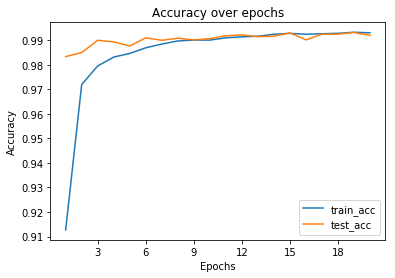

In [12]:
# plot the accuracy over epochs
plt.plot([int(x) for x in range(1, 21)], history.history['acc'], label = 'train_acc')
plt.plot([int(x) for x in range(1, 21)], history.history['val_acc'], label = 'test_acc')
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower', integer=True))
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

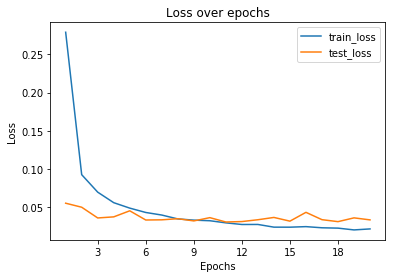

In [13]:
# plot the loss over epochs
plt.plot([int(x) for x in range(1, 21)], history.history['loss'], label = 'train_loss')
plt.plot([int(x) for x in range(1, 21)], history.history['val_loss'], label = 'test_loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower', integer=True))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
# find the predictions for test dataset
pred = model.predict(x_test)
pred = [np.argmax(p) for p in pred]

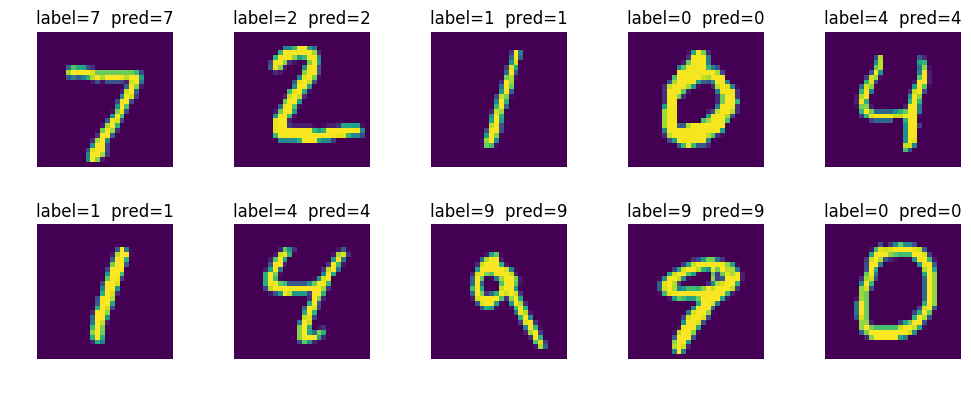

In [40]:
# plot the digits that were identified correctly
plt.figure(figsize=(10,4), dpi=100)
i=0
num_img = 0
while True:
    img = x_test[i]
    label = y_test[i]
    p = pred[i]
    if label==p:
        num_img+=1
        plt.subplot(2,5,num_img)
        plt.imshow(img.reshape(28,28))
        plt.title('label='+str(label) + '  ' + 'pred=' + str(p))
        plt.axis('off')
    i+=1
    if num_img>9 or i>x_test.shape[0]-1:
        break

plt.tight_layout()
plt.show()

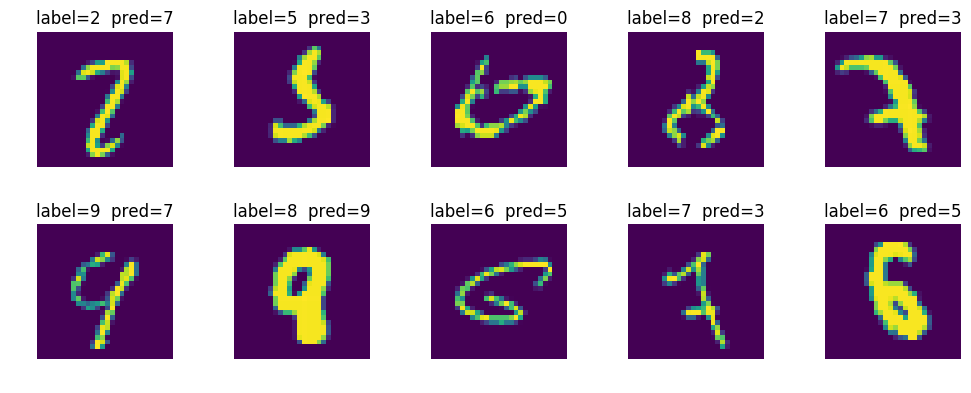

In [16]:
# plot the digits that were classified incorrectly
plt.figure(figsize=(10,4), dpi=100)
i=0
num_img = 0
while True:
    img = x_test[i]
    label = y_test[i]
    p = pred[i]
    if label!=p:
        num_img+=1
        plt.subplot(2,5,num_img)
        plt.imshow(img.reshape(28,28))
        plt.title('label='+str(label) + '  ' + 'pred=' + str(p))
        plt.axis('off')
    i+=1
    if num_img>9 or i>x_test.shape[0]-1:
        break

plt.tight_layout()
plt.show()

In [41]:
# find accuracy on train and test 
y_test = to_categorical(y_test, num_classes)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Test loss: 0.38232215209007264
Test accuracy: 0.8851
Train loss: 0.3908605176905791
Train accuracy: 0.8822833333333333


In [42]:
# save the model
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_mnist_cnn_network_trained_model_callback.h5'

In [43]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/i24009/Desktop/experiments-with-keras/saved_models/keras_mnist_cnn_network_trained_model_callback.h5 


In [44]:
# load saved model. can be trained from here as well
model = load_model(model_path)

In [46]:
# get the weights and bias for layers
W = model.layers[1].get_weights()
W = np.squeeze(W)
print("W shape : ", W.shape) 

W shape :  (2,)


In [47]:
# get the config for first layer
model.layers[1].get_config()

{'name': 'dense_1',
 'trainable': True,
 'batch_input_shape': (None, 784),
 'dtype': 'float32',
 'units': 512,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 1.0,
   'mode': 'fan_avg',
   'distribution': 'uniform',
   'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

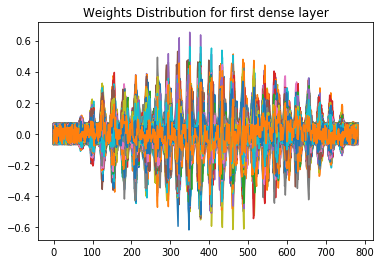

In [49]:
# plot the weight for first dense layer
plt.plot(W[0])
plt.title('Weights Distribution for first dense layer')
plt.show()

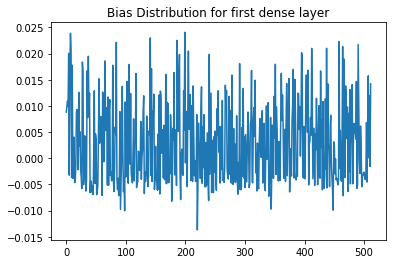

In [50]:
# plot the bias for first dense layer
plt.plot(W[1])
plt.title('Bias Distribution for first dense layer')
plt.show()

In [51]:
# get the second dense layer
W = model.layers[3].get_weights()
print("W shape : ", len(W) )

W shape :  2


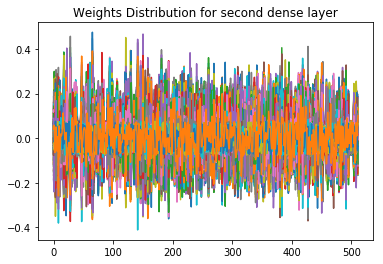

In [52]:
# plot the weight for the second dense layer
plt.plot(W[0])
plt.title('Weights Distribution for second dense layer')
plt.show()

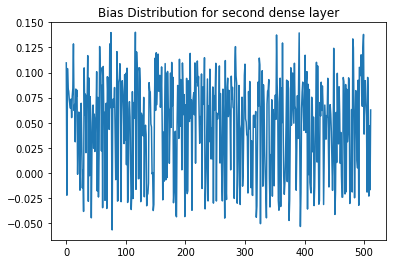

In [53]:
# plot the bias for the second dense layer
plt.plot(W[1])
plt.title('Bias Distribution for second dense layer')
plt.show()

In [54]:
# observe some values
len(W[0]), W[0][0]

(512, array([ 0.1119685 , -0.06410093,  0.07579877,  0.09431703, -0.04004071,
        -0.06668491, -0.11305826,  0.08095459,  0.1207689 ,  0.06542745,
         0.07493111, -0.01001419,  0.08706921, -0.02134266,  0.01182862,
         0.09029903,  0.0370498 ,  0.03737208,  0.01254297,  0.05960473,
         0.06795415,  0.00929167,  0.06526499,  0.07376473, -0.03227572,
        -0.0542784 ,  0.06652644, -0.05847843,  0.03761262, -0.05332993,
         0.03378823, -0.02330984, -0.03439862, -0.01928234, -0.00977742,
         0.05291207, -0.05726385,  0.01062732, -0.11760031,  0.07141503,
         0.10338727, -0.11469157,  0.03067638,  0.04098195, -0.04571382,
        -0.05804098, -0.03456383, -0.10163008, -0.04122104,  0.08308694,
        -0.1256225 , -0.0735889 , -0.00108062,  0.09615064, -0.06098225,
         0.00244449, -0.06460202,  0.10092888, -0.08374876,  0.04880663,
        -0.04369999, -0.05172579, -0.0112239 ,  0.02921139,  0.06967035,
         0.02710434, -0.00092981, -0.1465956 ,

In [55]:
# save plot model
plot_model(model, to_file='model.png')

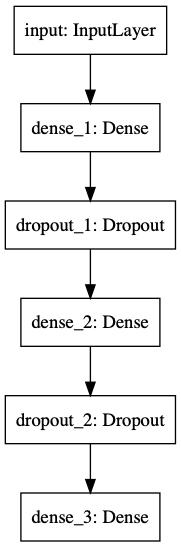

In [56]:
# show the model
Image(retina=True, filename='model.png')